In [19]:
import math
import QUANTAXIS as QA
import numpy as np
import pandas as pd
import statsmodels
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.stattools import adfuller
np.random.seed(107)
import matplotlib.pyplot as plt
from statsmodels.regression.linear_model import OLS

## Find pairs

In [43]:
# Get etf data
code_list= QA.QA_fetch_stock_block_adv().get_block('新能源').code

In [63]:
def find_pairs(code_list, start_date, end_date, method_type):
    n = len(code_list)
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            c1 = code_list[i]
            c2 = code_list[j]
            S1 = QA.QA_fetch_stock_day_adv(c1, start_date, end_date).to_qfq().close
            S2 = QA.QA_fetch_stock_day_adv(c2, start_date, end_date).to_qfq().close
            if len(S1)!= len(S2):
                continue
            if methods[method_type](S1, S2):
                pairs.append((c1, c2))
    return pairs

In [55]:
def ed_test(x, y):
    result = coint(list(x), list(y))
    score = result[0]
    pvalue = result[1]
    if pvalue < 0.05:
        return True
    return False
    

In [56]:
def adfuller_test(x, y):
    ols = OLS(x.to_list(), y.to_list()).fit()
    adf_result = adfuller(ols.resid)
    if adf_result[0] < adf_result[4]['5%']:
        return True
    return False

In [57]:
methods = {
    'ed': ed_test,
    'adf': adfuller_test
}

In [71]:
start_date = '2019-10-01'
end_date = '2020-10-01'

In [66]:
pairs_ed = find_pairs(code_list[:10], start_date, end_date, 'ed')

In [67]:
pairs_adf = find_pairs(code_list[:10], start_date, end_date, 'adf')

In [69]:
pairs_ed

[('002805', '300484'),
 ('002805', '600847'),
 ('002805', '300037'),
 ('002805', '600884'),
 ('600847', '300037'),
 ('600847', '300450'),
 ('600847', '600884'),
 ('002407', '600884')]

In [70]:
pairs_adf

[('603693', '300484'), ('002805', '600847'), ('600847', '300450')]

In [73]:
QA.QA_fetch_stock_day_adv(list(pairs_adf[0]),start_date, end_date).plot()


QUANTAXIS>> The Pic has been saved to your path: ./QA_stock_day_None_bfq.html


In [74]:
def get_ratios(code_x, code_y):
    x = QA.QA_fetch_stock_day_adv(code_x, start_date, end_date).to_qfq().close
    y = QA.QA_fetch_stock_day_adv(code_y, start_date, end_date).to_qfq().close
    x.index = y.index
    return x.div(y, axis = 'index')

In [80]:
def plot_zscore(series):  
    zscores = (series - series.mean()) / np.std(series)
    zscores.plot()
    plt.axhline(zscores.mean())
    plt.axhline(1.0, color='red')
    plt.axhline(-1.0, color='green')
    plt.show()

In [75]:
ratios = get_ratios(pairs_adf[0][0], pairs_adf[0][1])

/Users/feng/Tools/miniconda3/lib/python3.7/site-packages/pandas/plotting/_core.py:396: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


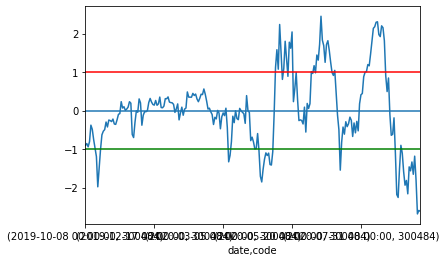

In [81]:
plot_zscore(ratios)

## Trading

In [86]:
def calc_zscore(ratios, window1, window2):
    strategy_name = 'pairs-trading'
    ma1 = ratios.rolling(window=window1,
                       center=False).mean()
    ma2 = ratios.rolling(window=window2,
                           center=False).mean()
    std = ratios.rolling(window=window2,
                    center=False).std()
    zscore = (ma1 - ma2)/std
    return zscore

In [93]:
zscores = calc_zscore(ratios, 5, 20)

In [107]:
code1 = '603693'
code2 = '300484'
# 策略名称
strategy_name = 'PAIRS'
# 用户cookie
user_cookie = 'tfw'
# 组合cookie
portfolio_cookie = 'win300'
# 账户cookie
account_cookie = 'bba'
benchmark_code = '399417' # 中证新能源车
initial_cash = 200000
initial_hold = {code1:100000, code2:100000}
# 交易佣金
commission_coeff = 0.00025
# 印花税
tax_coeff = 0.0015

backtest_start_date = '2020-01-01'
backtest_end_date = '2020-06-01'


In [92]:
Broker = QA.QA_BacktestBroker()
AC = QA.QA_Account(
    strategy_name=strategy_name,
    user_cookie=user_cookie,
    portfolio_cookie=portfolio_cookie,
    account_cookie=account_cookie,
    init_hold=initial_hold,
    init_cash=initial_cash,
    commission_coeff=commission_coeff,
    tax_coeff=tax_coeff,
    market_type=QA.MARKET_TYPE.STOCK_CN,
    frequence=QA.FREQUENCE.DAY
)

In [98]:
def place_order(order_code, order_time, order_amount,order_towards,market_item):
    order = AC.send_order(
                code=order_code,
                time=order_time,
                amount=order_amount,
                towards=order_towards,
                price=0,
                order_model=QA.ORDER_MODEL.CLOSE,
                amount_model=QA.AMOUNT_MODEL.BY_AMOUNT
            )
    if order:
        Broker.receive_order(QA.QA_Event(order=order,market_data=market_item))
        trade_mes=Broker.query_orders(AC.account_cookie,'filled')
        res=trade_mes.loc[order.account_cookie,order.realorder_id]
        order.trade(res.trade_id,res.trade_price,res.trade_amount,res.trade_time)
    else:
        raise SystemError("place order failed")
    
    
def pairs_backtest(AC:QA.QA_Account, code1, code2):
    for i,items in enumerate(DATA.panel_gen):
        item1 = items.select_code(code1)
        item2 = items.select_code(code2)
        order_time = items.date[0]   
        if zscores[i] > 1:             
            place_order(code2,order_time, 1000, QA.ORDER_DIRECTION.BUY,item2)
            place_order(code1,order_time, 1000, QA.ORDER_DIRECTION.SELL,item1)   
        if zscores[i] < -1:
            place_order(code2,order_time, 1000, QA.ORDER_DIRECTION.SELL,item2)
            place_order(code1,order_time, 1000, QA.ORDER_DIRECTION.BUY,item1)     
        AC.settle()

In [ ]:
pairs_backtest(AC, code1, code2)

<AxesSubplot:xlabel='date'>

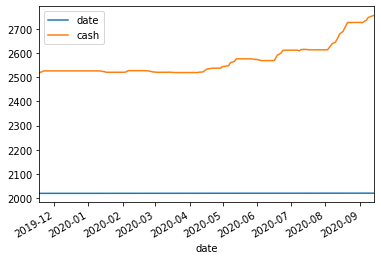

In [100]:
AC.daily_cash.plot()

In [ ]:
QA.QA_Risk(AC).message

In [102]:
AC.save()

{'account_cookie': 'bba', 'portfolio_cookie': 'win300', 'user_cookie': 'tfw', 'annualize_return': 2.17, 'profit': 1.76, 'max_dropback': 0.51, 'time_gap': 203, 'volatility': 1.26, 'benchmark_code': '399417', 'bm_annualizereturn': 0.61, 'bm_profit': 0.5, 'beta': 0.27, 'alpha': 2.01, 'sharpe': 1.68, 'sortino': -1.92, 'init_cash': '219245.63', 'last_assets': '605314.68', 'total_tax': -1445.32, 'total_commission': -820.0, 'profit_money': 386069.05, 'assets': [219245.63, 238971.065, 257736.665, 277482.1, 296647.61, 301447.61, 302397.61, 299847.61, 297097.61, 296697.61, 297947.61, 297947.61, 300147.61, 299597.61, 298847.61, 299047.61, 299197.61, 299147.61, 298747.61, 299947.61, 300447.61, 301197.61, 301947.61, 302847.61, 300947.61, 298297.61, 300447.61, 299997.61, 300547.61, 299247.61, 299547.61, 299797.61, 301197.61, 301547.61, 302247.61, 303597.61, 304947.61, 305047.61, 303247.61, 284662.595, 262887.91000000003, 262137.91, 241763.33000000002, 220889.035, 220919.035, 220669.035, 220529.035, 

/Users/feng/Tools/miniconda3/lib/python3.7/site-packages/pandas/plotting/_tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/feng/Tools/miniconda3/lib/python3.7/site-packages/pandas/plotting/_tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/feng/Tools/miniconda3/lib/python3.7/site-packages/pandas/plotting/_tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/feng/Tools/miniconda3/lib/python3.7/site-p

[]

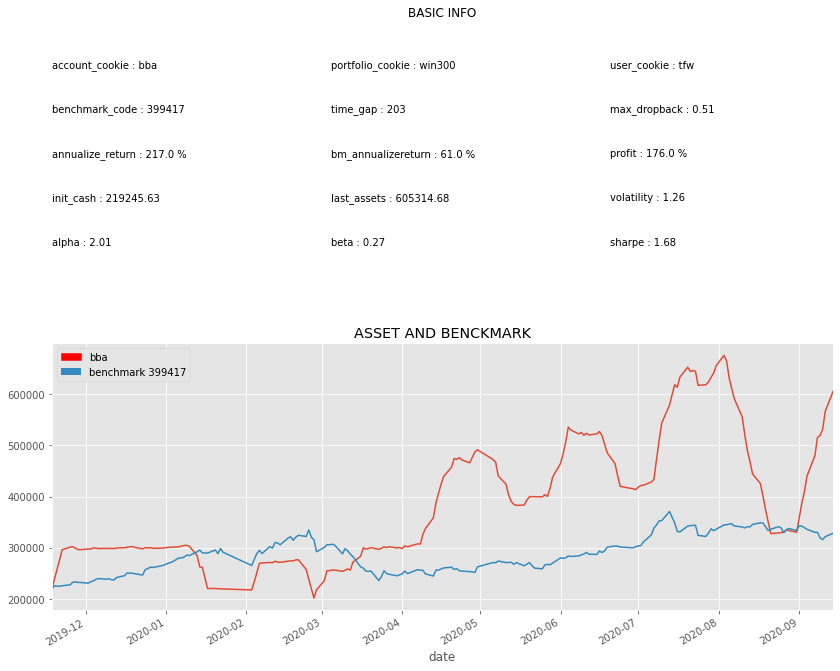

In [108]:
risk = QA.QA_Risk(account=AC, benchmark_code=benchmark_code, benchmark_type=QA.MARKET_TYPE.INDEX_CN, if_fq=False)
risk.save()

print(risk.message)
fig=risk.plot_assets_curve()

fig.plot()